# Transfer function parameters identification (based on experimental data).

A dynamic system has been excited using a step on its input.

The system's output $y(t)$ has been logged; the logging started when the step was applied, so when $t=0$. The
recorded datas are available in the file "data_system_ok.npz".

One would like to approximate this dynamic system with a model build on a second order transfer function
having 2 real poles and a dead-time : $$H_m(s) = \frac{Ke^{-sT_m}}{(sT_1 + 1)(sT_2 + 1)}$$

with:
- $K$, the system's static gain
- $T_m$, the dead-time
- $T_1$ and $T_2$, the 2 time constants

You're asked to :
- Find the transfer function's parameters, ensuring its step answer would fit as good as possible to the
experimental data. (Remember the tutorial about optimization)
- Plot on one unique chart the experimental datas and the model's answer, using for this one 500 points
equally distributed on the time duration of the experimental data.
- Compute and plot the model's poles in the complex domain.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import control as ct
from scipy.optimize import minimize

%config InlineBackend.figure_formats = ['svg']

In [2]:
npzfile = np.load('data_system_ok.npz')
npzfile

NpzFile 'data_system_ok.npz' with keys: t, y

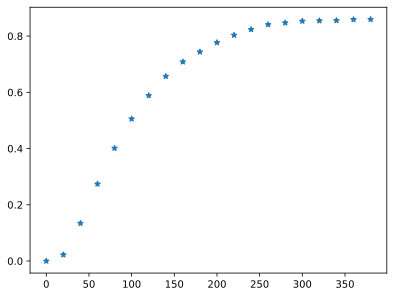

In [3]:
t = npzfile['t']
y = npzfile['y']
plt.plot(t, y, '*')
plt.show()

In [4]:
def syst(P):
    s = ct.tf('s')
    assert s is not None
    syst_no_dead_time = P[0]/((s*P[2]+1)*(s*P[3]+1))
    # Add dead time (time delay) using a Padé approximation
    num_delay, den_delay = ct.pade(P[1], 5)  # 5th-order Padé approximation
    dead_time = ct.TransferFunction(num_delay, den_delay)
    return syst_no_dead_time * dead_time

def response(P, t):
    H = syst(P)
    _, y = ct.step_response(H, t)
    return y

def cost(P, t, fun, y):
    return np.linalg.norm(fun(P, t) - y)

res = minimize(lambda P: cost(P, t, response, y), [1, 25, 50, 50], method='Nelder-Mead')
P_opt = res.x
P_opt

array([ 0.87240194,  9.01488149, 70.84910922, 26.13143975])

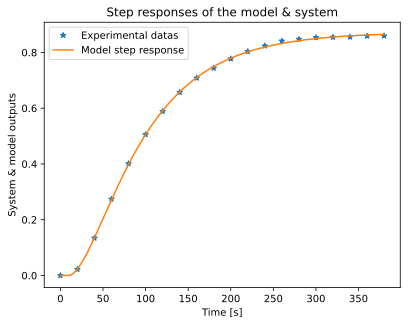

In [5]:
tm=np.linspace(0,t[-1],500)
ym=response(P_opt,tm)
assert ym is not None
plt.plot(t,y,'*', label="Experimental datas")
plt.plot(tm, ym, label="Model step response")
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('System & model outputs')
plt.title('Step responses of the model & system')
plt.show()

In [6]:
H = syst(P_opt)

ct.poles(H)

array([-0.51574151+0.79225066j, -0.51574151-0.79225066j,
       -0.74364958+0.38661882j, -0.74364958-0.38661882j,
       -0.80904859+0.j        , -0.03826808+0.j        ,
       -0.0141145 +0.j        ])

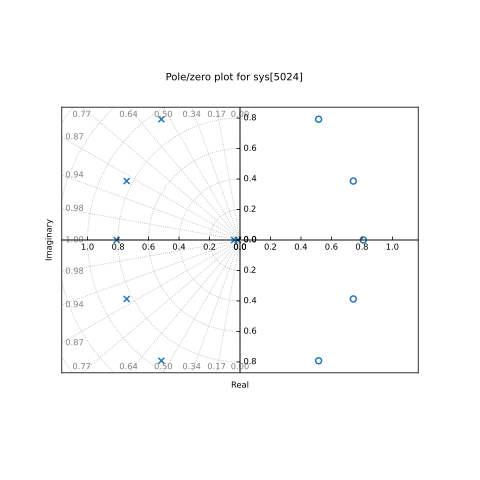

In [7]:
ct.pzmap(H, grid=True)
plt.show()